# Modeling

I first perform some data processing where I transform, scale and one-hot encode several features. Then, I train, validate and test a logistic regression model and a XGBoost classifier. I also do some basic work to address overfitting in the XGBoost classifier.

I provide some basic comments within some code cells to follow what the code does.

## Loading the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [2]:
### The DataFrame is wide, so we'd like to be able to see all columns
pd.set_option('display.max_columns', None)

### Let's load the data into a DataFrame and check some basic info
creditCard = pd.read_csv("../UCI_Credit_Card.csv")
creditCard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [3]:
### We'll rename 'default.payment.next.month' to 'DEFAULT' for simplicity
creditCard.rename({"default.payment.next.month": "DEFAULT"}, axis = 1, inplace = True)

### We'll rename 'PAY_0' to 'PAY_1' to keep consistency in namings
creditCard.rename({"PAY_0": "PAY_1"}, axis = 1, inplace = True)
creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Feature transformation

According to the EDA, some continuous features exhibit non-normality. Below we apply the transformations that showed better results in the EDA. 

In [4]:
creditCard["LIMIT_BAL_sqrt"] = np.sqrt(creditCard["LIMIT_BAL"])
creditCard["BILL_AMT1_cbrt"] = np.cbrt(creditCard["BILL_AMT1"])

cols = ["PAY_AMT1", "PAY_AMT2", "PAY_AMT3", "PAY_AMT4", "PAY_AMT5", "PAY_AMT6"]
for col in cols:
    name = col + "_log"
    creditCard[name] = np.log(creditCard[col] + abs(creditCard[col].min()) + 0.001)

creditCard.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,141.421356,15.758079,-6.907755,6.535243,-6.907755,-6.907755,-6.907755,-6.907755
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,346.410162,13.893754,-6.907755,6.907756,6.907756,6.907756,-6.907755,7.600903
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,300.000000,30.807338,7.325150,7.313221,6.907756,6.907756,6.907756,8.517193
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,223.606798,36.085701,7.600903,7.610358,7.090078,7.003066,6.974480,6.907756
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,223.606798,20.501487,7.600903,10.510014,9.210340,9.104980,6.535243,6.520623


## Feature scaling

We scale all continuous features using the Min-Max scaler. This scaler scales a feature in the range `[0, 1]` or in the range `[-1, 1]` if the feature has negative values.

In [5]:
### We extract the features that are going to be scaled
cols = ["LIMIT_BAL_sqrt", "BILL_AMT1_cbrt", "PAY_AMT1_log", "PAY_AMT2_log", "PAY_AMT3_log", "PAY_AMT4_log", \
    "PAY_AMT5_log", "PAY_AMT6_log", "AGE"]
creditCard_scaled = creditCard[cols].copy()

### We apply the min-max scaler
scaler = preprocessing.MinMaxScaler()
creditCard_scaled[cols] = scaler.fit_transform(creditCard_scaled[cols])
creditCard_scaled.head()

,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,AGE
0,0.046024,0.459749,0.000000,0.632773,0.000000,0.000000,0.000000,0.000000,0.051724
1,0.273789,0.447621,0.000000,0.650307,0.670217,0.682354,0.000000,0.722332,0.086207
2,0.222222,0.557653,0.691318,0.669393,0.670217,0.682354,0.695253,0.767950,0.224138
3,0.137341,0.591991,0.704712,0.683379,0.679062,0.687061,0.698611,0.687823,0.275862
4,0.137341,0.490608,0.704712,0.819868,0.781920,0.790876,0.676507,0.668549,0.620690


## One-hot encoding

We dummify all categorical features.

In [6]:
### For the sake of thoroughness, we convert the categorical features into actual categorical features 
cols = ["SEX", "EDUCATION", "MARRIAGE", "PAY_1", "PAY_2", "PAY_3", "PAY_4", "PAY_5", "PAY_6"]
creditCard[cols] = creditCard[cols].astype("category")
creditCard_dumm = creditCard[cols].copy()

### We dummify all the categorical features
creditCard_dumm = pd.get_dummies(creditCard_dumm, columns = cols, drop_first = True)
creditCard_dumm.head()

,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Processed DataFrame

We bring all transformations, scalings and dummies into a single DataFrame.

In [7]:
### We concatenate the scaled features with the dummified features
creditCard_ml = pd.concat([creditCard_scaled, creditCard_dumm], axis = 1)

### We delete intermediate DataFrames
del creditCard_scaled, creditCard_dumm

creditCard_ml.head()

,LIMIT_BAL_sqrt,BILL_AMT1_cbrt,PAY_AMT1_log,PAY_AMT2_log,PAY_AMT3_log,PAY_AMT4_log,PAY_AMT5_log,PAY_AMT6_log,AGE,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_1_-1,PAY_1_0,PAY_1_1,PAY_1_2,PAY_1_3,PAY_1_4,PAY_1_5,PAY_1_6,PAY_1_7,PAY_1_8,PAY_2_-1,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-1,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-1,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,0.046024,0.459749,0.000000,0.632773,0.000000,0.000000,0.000000,0.000000,0.051724,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.273789,0.447621,0.000000,0.650307,0.670217,0.682354,0.000000,0.722332,0.086207,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0.222222,0.557653,0.691318,0.669393,0.670217,0.682354,0.695253,0.767950,0.224138,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.137341,0.591991,0.704712,0.683379,0.679062,0.687061,0.698611,0.687823,0.275862,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.137341,0.490608,0.704712,0.819868,0.781920,0.790876,0.676507,0.668549,0.620690,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


## Training, validation and test set splitting

We split the dataset into training, validation and test sets. Comparing training and validation errors will allow us to assess whether a model is underfitting (has a high bias) or overfitting (has a high variance) the data.

Underfitting means the model isn't doing well in the training set (the training error is high and the validation error is similar), while overfitting means the model isn't doing well in the validation set (the training error may be low but the validation error is much higher).

Note that to assess whether a model is doing well in the training set (is the training error high?) we need a baseline level of performance. To establish this baseline level, we need to determine what's the error level we hope our model can get to. Common ways of establishing this baseline level are measuring how well humans do in the task, using the performance of a competing algorithm as the baseline level or using an informed guess based on prior experience.

Comparing validation errors among several models will allow us to select a model. Finally, once a model is selected, its test error is taken as the model's generalization error.

Note the validation set is often called cross-validation set. Cross-validation can also refer to the k-fold cross-validation procedure. I use the terms validation set and validation error to avoid confusion with the k-fold cross-validation procedure.

In [8]:
### Let's split the dataset into training, validation and test sets keeping class proportions

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables: x_ and y_
x_train, x_, y_train, y_ = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.40, random_state = 1, \
    stratify = creditCard["DEFAULT"])

# Split the 40% subset above into two: one half for the validation set and the other for the test set
x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size = 0.50, random_state = 1, \
    stratify = y_)

# Delete temporary variables
del x_, y_

In [9]:
### Let's check the size of the 3 sets

print(f"The shape of the training set (input) is: {x_train.shape}")
print(f"The shape of the training set (target) is: {y_train.shape}")
print(f"\nThe shape of the validation set (input) is: {x_val.shape}")
print(f"The shape of the validation set (target) is: {y_val.shape}")
print(f"\nThe shape of the test set (input) is: {x_test.shape}")
print(f"The shape of the test set (target) is: {y_test.shape}")

The shape of the training set (input) is: (18000, 77)
The shape of the training set (target) is: (18000,)

The shape of the validation set (input) is: (6000, 77)
The shape of the validation set (target) is: (6000,)

The shape of the test set (input) is: (6000, 77)
The shape of the test set (target) is: (6000,)


In [10]:
### Let's check whether the proportion of classes is similar among the 3 sets

print("TRAINING set")
print("Proportion of defaulters: " + str(len(y_train.loc[y_train == 1])/len(y_train)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_train.loc[y_train == 0])/len(y_train)))
print("\nVALIDATION set")
print("Proportion of defaulters: " + str(len(y_val.loc[y_val == 1])/len(y_val)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_val.loc[y_val == 0])/len(y_val)))
print("\nTEST set")
print("Proportion of defaulters: " + str(len(y_test.loc[y_test == 1])/len(y_test)) + "\n" + \
     "Proportion of non-defaulters " + str(len(y_test.loc[y_test == 0])/len(y_test)))

TRAINING set
Proportion of defaulters: 0.2212222222222222
Proportion of non-defaulters 0.7787777777777778

VALIDATION set
Proportion of defaulters: 0.22116666666666668
Proportion of non-defaulters 0.7788333333333334

TEST set
Proportion of defaulters: 0.22116666666666668
Proportion of non-defaulters 0.7788333333333334


## Logistic regression

Without a baseline performance level to assess whether the training set is performing well, we can only assess whether the model is overfitting by comparing the training and validation errors. Both errors are pretty similar (there's less than a 1% difference between them), which indicates the model isn't overfitting the data.

Note we use verbosity for printing some log from the training process and a random state for ensuring reproducibility.

In [11]:
### Let's train our logistic regression model

# The default configuration doesn't work properly. We increased the iterations
    # https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter

logisticRegr = LogisticRegression(max_iter = 200, verbose = 1, random_state = 1)
logisticRegr.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s finished


LogisticRegression(max_iter=200, random_state=1, verbose=1)

In [12]:
### Let's check the accuracy and error (MSE) of the training set

y_pred = logisticRegr.predict(x_train)
accuracy_training = logisticRegr.score(x_train, y_train) # metrics.accuracy_score(y_train, y_pred) delivers the same score
mse_training = metrics.mean_squared_error(y_train, y_pred)
print("Accuracy on training set: ", accuracy_training)
print("MSE on training set: ", mse_training)
print("1 - MSE: ", 1 - mse_training) # Just to check the relationship between accuracy and MSE

Accuracy on training set:  0.8223888888888888
MSE on training set:  0.1776111111111111
1 - MSE:  0.8223888888888888


In [13]:
### Let's check the accuracy and error of the validation set

y_pred = logisticRegr.predict(x_val)
accuracy_val = logisticRegr.score(x_val, y_val)
mse_val = metrics.mean_squared_error(y_val, y_pred)
print("Accuracy on validation set: ", accuracy_val)
print("MSE on validation set: ", mse_val)

Accuracy on validation set:  0.8168333333333333
MSE on validation set:  0.18316666666666667


In [14]:
### Let's check the accuracy and error of the test set

y_pred = logisticRegr.predict(x_test)
accuracy_test = logisticRegr.score(x_test, y_test)
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8238333333333333
MSE on test set:  0.17616666666666667


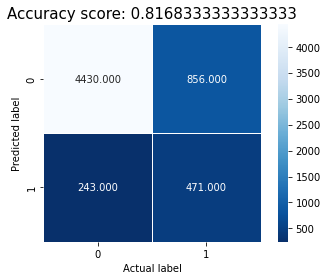

In [15]:
### Let's compute and plot the confusion matrix (on the validation set)

# We compute the model predictions using the validation set
y_pred = logisticRegr.predict(x_val)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "Accuracy score: {0}".format(accuracy_val)
plt.title(all_sample_title, size = 15)
plt.show()

In [16]:
### Let's check the F1 score

"""
# We can manually compute the relevant scores from the confusion matrix
precision = cm[1,1] / (cm[1,1] + cm[1,0])
recall = cm[1,1] / (cm[1,1] + cm[0,1] )
f1 = 2*precision*recall/(precision+recall)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 score: ", f1)
"""

print("Precision: ", metrics.precision_score(y_val, y_pred))
print("Recall: ", metrics.recall_score(y_val, y_pred))
print("F1 score: ", metrics.f1_score(y_val, y_pred))

Precision:  0.6596638655462185
Recall:  0.3549359457422758
F1 score:  0.4615384615384616


## Extreme Gradient Boosting (XGBoost)

Without a baseline performance level to assess whether the training set is performing well, we can only assess whether the model is overfitting by comparing the training and validation errors. With the `XGBClassifier()` default implementation, the validation error is somewhat higher than the training error (there's a 7% difference between them), which indicates the model is somewhat overfitting the data.

In the next two sections we explore some basic strategies to reduce overfitting.

In [17]:
### Let's train our XGBoost classifier

xgbClass = XGBClassifier(verbosity = 1, random_state = 1)
xgbClass.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=1,
              reg_alpha=0, reg_lambda=1, ...)

In [18]:
### Let's check the accuracy and error of the training set

y_pred = xgbClass.predict(x_train)
accuracy_training = xgbClass.score(x_train, y_train)
mse_training = metrics.mean_squared_error(y_train, y_pred)
print("Accuracy on training set: ", accuracy_training)
print("MSE on training set: ", mse_training)

Accuracy on training set:  0.8895
MSE on training set:  0.1105


In [19]:
### Let's check the accuracy and error of the validation set

y_pred = xgbClass.predict(x_val)
accuracy_val = xgbClass.score(x_val, y_val)
mse_val = metrics.mean_squared_error(y_val, y_pred)
print("Accuracy on cross validation set: ", accuracy_val)
print("MSE on cross validation set: ", mse_val)

Accuracy on cross validation set:  0.8126666666666666
MSE on cross validation set:  0.18733333333333332


In [20]:
### Let's check the accuracy and error of the test set

y_pred = xgbClass.predict(x_test)
accuracy_test = xgbClass.score(x_test, y_test)
mse_test = metrics.mean_squared_error(y_test, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8175
MSE on test set:  0.1825


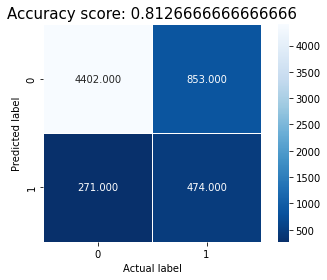

In [21]:
### Let's compute and plot the confusion matrix (on the validation set)

# We compute the model predictions using the validation set
y_pred = xgbClass.predict(x_val)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_val, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "Accuracy score: {0}".format(accuracy_val)
plt.title(all_sample_title, size = 15)
plt.show()

In [22]:
### Let's check the F1 score

print("Precision: ", metrics.precision_score(y_val, y_pred))
print("Recall: ", metrics.recall_score(y_val, y_pred))
print("F1 score: ", metrics.f1_score(y_val, y_pred))

Precision:  0.636241610738255
Recall:  0.3571966842501884
F1 score:  0.4575289575289575


### Overfitting

We can tune several parameters to reduce overfitting. Please visit [Parameters for Tree Booster](https://xgboost.readthedocs.io/en/stable/parameter.html#parameters-for-tree-booster) and [this question from Stack Exchange](https://stats.stackexchange.com/questions/443259/how-to-avoid-overfitting-in-xgboost-model) for more info on what parameters can be tuned to reduce overfitting. We play with some common choices:

#### subsample

`xgbClass = XGBClassifier(subsample = 0.5, verbosity = 1, random_state = 1)`: overfitting doesn't improve.

#### max_depth

`xgbClass = XGBClassifier(max_depth = 4, verbosity = 1, random_state = 1)`: from 4 downwards overfitting improves.

#### learning_rate

`xgbClass = XGBClassifier(learning_rate = 0.1, verbosity = 1, random_state = 1)`: from 0.1 downwards overfitting improves.

#### min_split_loss

`xgbClass = XGBClassifier(min_split_loss = 3, verbosity = 1, random_state = 1)`: from 3 upwards overfitting improves.

#### early_stopping_rounds

    x_train_fit, x_train_eval, y_train_fit, y_train_eval = train_test_split(x_train, y_train, test_size = 0.2, \
        random_state = 1, stratify = y_train)   
    xgbClass = XGBClassifier(verbosity = 1, random_state = 1)
    xgbClass.fit(x_train_fit, y_train_fit, eval_set = [(x_train_eval, y_train_eval)], early_stopping_rounds = 10)
    y_pred = xgbClass.predict(x_train_fit)
    accuracy_training = xgbClass.score(x_train_fit, y_train_fit)
    mse_training = metrics.mean_squared_error(y_train_fit, y_pred)
    print("Accuracy on training set: ", accuracy_training)
    print("MSE on training set: ", mse_training)

This early stopping implementation somewhat improves overfitting.

### Cross-validation

We can also use cross-validation to reduce overfitting. The work below relies heavily on the process I followed while learning about how to make predictions after cross-validating a model. Most of this process is captured in a [question I posted myself in Stack Overflow](https://stackoverflow.com/questions/75454460/does-it-make-sense-to-use-scikit-learn-cross-val-predict-to-imake-prediction).

Note we use a XGBoost classifier with its default implementation for illustrative purposes. A more rigorous approach would require to systematically explore how the model performs with several parameter values using cross-validation. We briefly discuss this in the **Summary** section at the end of this notebook.

In [23]:
# We split the data on training and test sets. The training set is the one used in the cross-validation
x_trainf, x_testf, y_trainf, y_testf = train_test_split(creditCard_ml, creditCard["DEFAULT"], test_size = 0.20, \
    random_state = 1, stratify = creditCard["DEFAULT"])

xgbClassCrossVal = XGBClassifier()
kfold = StratifiedKFold(n_splits = 10)
results_kfold = cross_val_score(xgbClassCrossVal, x_trainf, y_trainf, cv = kfold)
print("Accuracy: %.2f%% (%.2f%%)" % (results_kfold.mean()*100, results_kfold.std()*100))

Accuracy: 81.40% (0.61%)


In [24]:
### Let's check the accuracy and error of the internal test sets from the cross-validation procedure

y_pred = cross_val_predict(xgbClassCrossVal, x_trainf, y_trainf, cv = kfold)
accuracy_test = metrics.accuracy_score(y_trainf, y_pred)
mse_test = metrics.mean_squared_error(y_trainf, y_pred)
print("Accuracy on internal test sets: ", accuracy_test)
print("MSE on internal test sets: ", mse_test)

Accuracy on internal test sets:  0.814
MSE on internal test sets:  0.186


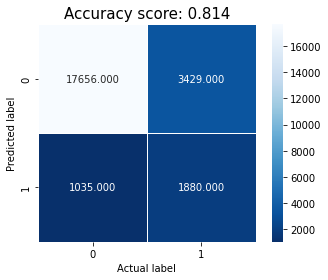

In [25]:
### Let's compute and plot the confusion matrix (on the internal test sets from the cross-validation procedure)

# We compute the confusion matrix
cm = metrics.confusion_matrix(y_trainf, y_pred).T

# We plot the confusion matrix
sns.heatmap(cm, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues_r")
plt.xlabel("Actual label")
plt.ylabel("Predicted label")
all_sample_title = "Accuracy score: {0}".format(accuracy_test)
plt.title(all_sample_title, size = 15)
plt.show()

In [26]:
### Let's check the F1 score

print("Precision: ", metrics.precision_score(y_trainf, y_pred))
print("Recall: ", metrics.recall_score(y_trainf, y_pred))
print("F1 score: ", metrics.f1_score(y_trainf, y_pred))

Precision:  0.6449399656946827
Recall:  0.3541156526652854
F1 score:  0.4571984435797665


The following code helps check that `cross_val_predict()` works fine:

    import copy as cp
    from typing import Tuple
    
    def cross_val_predict_y(model, kfold : kfold, X : np.array, y : np.array) -> Tuple[np.array, np.array, np.array]:

        model_ = cp.deepcopy(model)
        
        no_classes = len(np.unique(y))
        
        actual_classes = np.empty([0], dtype=int)
        predicted_classes = np.empty([0], dtype=int)
        predicted_proba = np.empty([0, no_classes]) 

        for train_ndx, test_ndx in kfold.split(X, y):

            train_X, train_y, test_X, test_y = X[train_ndx], y[train_ndx], X[test_ndx], y[test_ndx]

            actual_classes = np.append(actual_classes, test_y)

            model_.fit(train_X, train_y)
            predicted_classes = np.append(predicted_classes, model_.predict(test_X))

            try:
                predicted_proba = np.append(predicted_proba, model_.predict_proba(test_X), axis=0)
            except:
                predicted_proba = np.append(predicted_proba, np.zeros((len(test_X), no_classes), dtype=float), axis=0)

        return actual_classes, predicted_classes, predicted_proba

    actual_classes, predicted_classes, _ = cross_val_predict_y(xgbClassCrossVal, kfold, \
        x_trainf.to_numpy(), y_trainf.to_numpy())

We can then compute the accuracy, confusion matrix and F1 score using `actual_classes` and `predicted_classes`:

    score = metrics.accuracy_score(actual_classes, predicted_classes)
    cm = metrics.confusion_matrix(actual_classes, predicted_classes).T
    f1_score = metrics.f1_score(actual_classes, predicted_classes)

The accuracy, confusion matrix and F1 score should be the same as the ones obtained after running `cross_val_predict()`. The helper function `cross_val_predict_y()` is borrowed from [How to plot a confusion matrix from a k-fold cross-validation](https://towardsdatascience.com/how-to-plot-a-confusion-matrix-from-a-k-fold-cross-validation-b607317e9874).

In [27]:
### Let's make predictions on the test set and compute the generalization error

# We perform a grid search on the cross-validation models
xgbClassGrid = GridSearchCV(estimator = xgbClassCrossVal, param_grid = {}, cv = kfold)
xgbClassGrid.fit(x_trainf, y_trainf)

# We select the best model from the cross-validation to make predictions
y_pred = xgbClassGrid.best_estimator_.predict(x_testf)

# We check the accuracy and error of the test set
accuracy_test = metrics.accuracy_score(y_testf, y_pred)
mse_test = metrics.mean_squared_error(y_testf, y_pred)
print("Accuracy on test set: ", accuracy_test)
print("MSE on test set: ", mse_test)

Accuracy on test set:  0.8153333333333334
MSE on test set:  0.18466666666666667


## Summary

Comparing the results from the logistic regression to the results from the cross-validated XGBoost classifier, we can conclude that both models perform virtually the same:

| Model                     | Accuracy  | Precision | Recall    | F1 score  | Generalization error  |
| ---                       | ---       | ---       | ---       | ---       | ---                   |
| Logistic regression       | 0.8168    | 0.6597    | 0.3549    | 0.4615    | 0.1762                |
| Cross-validated XGBoost   | 0.8140    | 0.6449    | 0.3541    | 0.4572    | 0.1847                |

Overall, although the accuracy seems relatively high, the confusion matrices and their metrics tell us both models are rather poor. In particular, both of them have a high number of false positives (see the Recall). More details on how to interpret a confusion matrix and its metrics can be found in [What does your classification metric tell about your data?](https://towardsdatascience.com/what-does-your-classification-metric-tell-about-your-data-4a8f35408a8b)

Note we only did some basic work to address overfitting. A more rigorous approach would require to perform a hyperpameter tuning using cross-validation. For example, this process would help us determine what are the best `max_depth` and `learning_rate` (among other hyperparameters) for our XGBoost classifier (e.g., see [A guide on XGBoost hyperparameters tuning](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook)). The process can also be run for the logistic regression, although the impact can be rather small (e.g., see [Do I need to tune logistic regression hyperparameters?](https://medium.com/codex/do-i-need-to-tune-logistic-regression-hyperparameters-1cb2b81fca69)). The blog entry [Cross-validation and hyperparameter tuning: how to optimise your machine learning model](https://towardsdatascience.com/cross-validation-and-hyperparameter-tuning-how-to-optimise-your-machine-learning-model-13f005af9d7d) is a great resource to understand how this process works. Moreover, it packs most of the estimation and evaluation work I do here in a single method :astonished: :muscle: